# Learning Models

In [12]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, KFold
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("fivethirtyeight")

In [13]:
#number of top films to keep in my dataset
num_top_films_for_model = 10000
#number of movies to get top directors and writers
cream_of_the_crop = 250

In [14]:
movies = pd.read_csv("../data/movies.csv")

#getting the top 10000 films of all time
movies = movies.sort_values(by=['score'], ascending=False).head(num_top_films_for_model)

In [15]:
#getting the writers and directors from the top 250 films of all time. 
#These are the top 1% of Hollywood and they are the only ones that matter
best_directors = movies.sort_values(by=['score', 'directors'], ascending=False).head(cream_of_the_crop)['directors'].unique().tolist()
best_writers = movies.sort_values(by=['score', 'writers'], ascending=False).head(cream_of_the_crop)['writers'].unique().tolist()

#the bottom 99% will do into these replaceable lists
replacable_directors = []
replacable_writers = []

for x in movies['directors']:
    if x not in best_directors:
        replacable_directors.append(x)
        
for x in movies['writers']:
    if x not in best_directors:
        replacable_writers.append(x)       

In [16]:
#replacing the bottom 99% 's unique ID number with 'unknown'
#this will help when getting dummies
movies.replace(replacable_directors, 'unknown', inplace=True)
movies.replace(replacable_writers, 'unknown', inplace=True)

In [17]:
#get dummies for: genres directors, writers
genre_dummies = pd.get_dummies(movies['genres'])
director_dummies = pd.get_dummies(movies['directors'])
writer_dummies = pd.get_dummies(movies['writers'])

frames = [movies['startYear'], genre_dummies, director_dummies, writer_dummies, movies['runtimeMinutes'], movies['averageRating']]

### Getting DataFrame Ready for ML

In [18]:
#creating a ready for model df that has only the relavant features and target
ready_for_model = pd.concat(frames, axis=1)
ready_for_model = ready_for_model.drop(['unknown'], axis=1)

## Regression Models
Imports, TT splits, and functions to output  model RMSEs and baseline RMSE

In [19]:
import sklearn.model_selection as sk
import sklearn.metrics as sk
import sklearn.ensemble as ske

from sklearn.model_selection import GridSearchCV



### Train Test Split

In [20]:
#features are: year, genre dummies, writer/director dummies, runtime
X = ready_for_model.drop(['averageRating'], axis=1)
#target is: average rating
y = ready_for_model['averageRating']
X_train, X_test, y_train, y_test = train_test_split(X, y)

### Functions to output model RMSEs and baseline RMSE

In [21]:
#function that does the following:
#train test split, fit, and prediction
#measures model with rmse
#prints model name and rmse
def regression_model(X, y, my_model):
    model = my_model
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    rmse = sk.mean_squared_error(y_test,predicted)
    return rmse

    
#java style getter method to get baseline rmse
def get_baseline_rmse(df):
    set_mean = df['averageRating'].mean()
    df['error'] = df['averageRating'] - set_mean
    summation = 0
    for x in df['error']:
        summation += x**2
    
    return (summation/df['error'].size)**(0.5)

### LinearRegression() , GradientBoostingRegressor(), and RandomForestRegressor()

In [23]:
print("LINEAR REGRESSION RMSLE: {}".format(regression_model(X, y, LinearRegression())))
print("GRADIENT BOOSTING RMSLE: {}".format(regression_model(X, y, ske.GradientBoostingRegressor())))
print("RANDOM FOREST REG. RMSLE: {}".format(regression_model(X, y, ske.RandomForestRegressor())))
print('BASELINE RMSLE: {}'.format(get_baseline_rmse(ready_for_model)))

LINEAR REGRESSION RMSLE: 3.07449271189934e+18
GRADIENT BOOSTING RMSLE: 0.37371414623157234
RANDOM FOREST REG. RMSLE: 0.4536854367565796
BASELINE RMSLE: 0.7268794428239123


### Visualizing Performance

CPU times: user 8.4 s, sys: 217 ms, total: 8.62 s
Wall time: 9.76 s


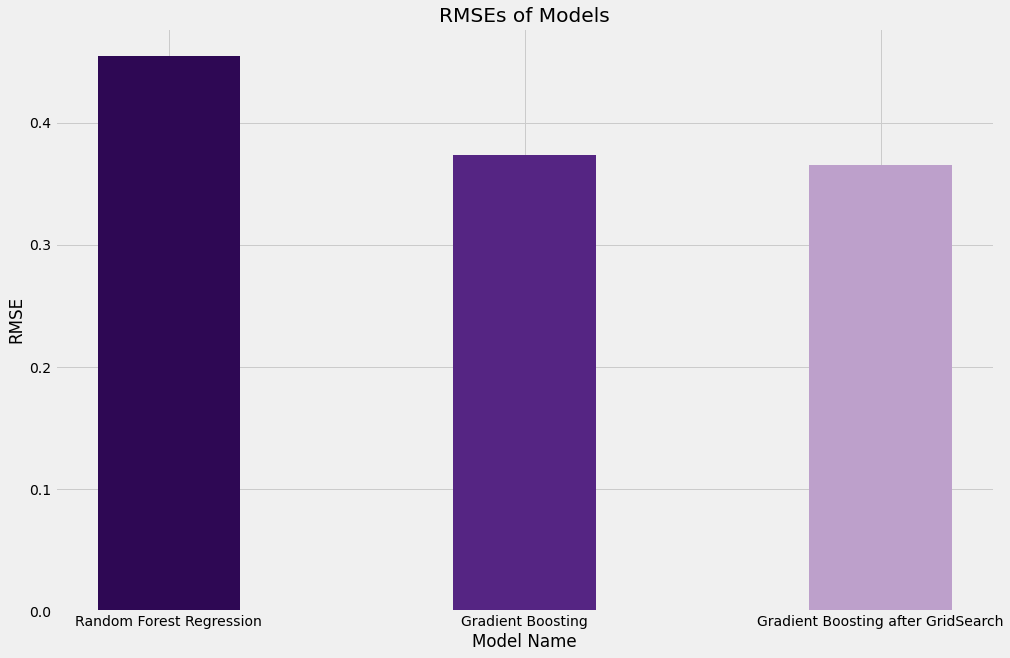

In [68]:
model_names = [
               "Random Forest Regression", 
               "Gradient Boosting", 
               "Gradient Boosting after GridSearch"]
errors = [
          regression_model(X, y, ske.RandomForestRegressor()),
         regression_model(X, y, ske.GradientBoostingRegressor()),
         0.36502637892354994]

fig, ax = plt.subplots(figsize=(15, 10))


ax.bar(model_names, errors, color=['#2E0854', '#552583', '#BDA0CB'], width=0.4)
ax.set_xlabel("Model Name")
ax.set_ylabel("RMSE")
ax.set_title("RMSEs of Models")

plt.savefig('../graphs/model_performance.png')



### Trying different hyperparameters on Gradient Boosting

In [66]:
gradient_boosting_grid = {'learning_rate': [0.1, 0.05, 0.02, 0.01],
                          'max_depth': [2, 4, 6],
                          'min_samples_leaf': [1, 2, 5, 10],
                          'n_estimators': [500],
                          'random_state': [1]}

In [67]:
gdbr_best_model = GridSearchCV(ske.GradientBoostingRegressor(),
                                                           gradient_boosting_grid, verbose=1
                                                )




Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed: 56.9min finished


GridSearchCV(estimator=GradientBoostingRegressor(),
             param_grid={'learning_rate': [0.1, 0.05, 0.02, 0.01],
                         'max_depth': [2, 4, 6],
                         'min_samples_leaf': [1, 2, 5, 10],
                         'n_estimators': [500], 'random_state': [1]},
             verbose=1)

In [1]:
gdbr_best_model.fit(X_train, y_train)

NameError: name 'gdbr_best_model' is not defined

In [2]:
gdbr_best_model.predict(X_test)
best_params = gdbr_best_model.best_params_
best_model = gdbr_best_model.best_estimator_
print("GRADIENT BOOSTING RMSLE AFTER GRID SEARCH: {}".format(regression_model(X, y, best_model)))

NameError: name 'gdbr_best_model' is not defined

## Summarizing everything

In [141]:
print('BASELINE RMSLE: {}'.format(get_baseline_rmse(ready_for_model)))
print('-----------------------------------------------')
print("LINEAR REGRESSION RMSLE: {}".format(regression_model(X, y, LinearRegression())))
print()
print("GRADIENT BOOSTING RMSLE: {}".format(regression_model(X, y, ske.GradientBoostingRegressor())))
print()
print("RANDOM FOREST REG. RMSLE: {}".format(regression_model(X, y, ske.RandomForestRegressor())))
print()
print("GRADIENT BOOSTING GRID: {}".format(gradient_boosting_grid))
print()
print("BEST PARAMERETS FROM GRID SEARCH: {}".format(best_params))
print()
print("GRADIENT BOOSTING RMSLE AFTER GRID SEARCH: {}".format(regression_model(X, y, best_model)))

BASELINE RMSLE: 0.7268794428239123
-----------------------------------------------
LINEAR REGRESSION RMSLE: 1.094594555756381e+18

GRADIENT BOOSTING RMSLE: 0.36979547935642426

RANDOM FOREST REG. RMSLE: 0.459659835407462

GRADIENT BOOSTING GRID: {'learning_rate': [0.1, 0.05, 0.02, 0.01], 'max_depth': [2, 4, 6], 'min_samples_leaf': [1, 2, 5, 10], 'n_estimators': [500], 'random_state': [1]}

BEST PARAMERETS FROM GRID SEARCH: {'learning_rate': 0.02, 'max_depth': 6, 'min_samples_leaf': 2, 'n_estimators': 500, 'random_state': 1}

GRADIENT BOOSTING RMSLE AFTER GRID SEARCH: 0.36502637892354994
